# Multiclass logistic regression with ``gluon``

Now that we've built a [logistic regression model from scratch](./softmax-regression-scratch.ipynb), let's make this more efficient with ``gluon``. If you completed the corresponding chapters on linear regression, you might be tempted rest your eyes a little in this one. We'll be using ``gluon`` in a rather similar way and since the interface is reasonably well designed, you won't have to do much work. To keep you awake we'll introduce a few subtle tricks. 

Let's start by importing the standard packages. 

In [39]:
from __future__ import print_function
import mxnet as mx
from mxnet import nd, autograd
from mxnet import gluon
import numpy as np

## Set the context

Now, let's set the context. In the linear regression tutorial we did all of our computation on the cpu (`mx.cpu()`) just to keep things simple. When you've got 2-dimensional data and scalar labels, a smartwatch can probably handle the job. Already, in this tutorial we'll be working with a considerably larger dataset. If you happen to be running this code on a server with a GPU and installed the GPU-enabled version of MXNet (or remembered to build MXNet with ``CUDA=1``), you might want to substitute the following line for its commented-out counterpart.

In [40]:
data_ctx = mx.cpu()
model_ctx = mx.cpu()

## The MNIST Dataset

We won't suck up too much wind describing the MNIST dataset for a second time. If you're unfamiliar with the dataset and are reading these chapters out of sequence, take a look at the data section in the previous chapter on [softmax regression from scratch](./softmax-regression-scratch.ipynb).


We'll load up data iterators corresponding to the training and test splits of MNIST dataset. 

In [41]:
batch_size = 64
num_inputs = 784
num_outputs = 10
num_examples = 60000
def transform(data, label):
    return data.astype(np.float32)/255, label.astype(np.float32)
train_data = mx.gluon.data.DataLoader(mx.gluon.data.vision.MNIST(train=True, transform=transform),
                                      batch_size, shuffle=True)
test_data = mx.gluon.data.DataLoader(mx.gluon.data.vision.MNIST(train=False, transform=transform),
                              batch_size, shuffle=False)

We're also going to want to load up an iterator with *test* data. After we train on the training dataset we're going to want to test our model on the test data. Otherwise, for all we know, our model could be doing something stupid (or treacherous?) like memorizing the training examples and regurgitating the labels on command.

## Multiclass Logistic Regression

Now we're going to define our model. 
Remember from [our tutorial on linear regression with ``gluon``](./P02-C02-linear-regression-gluon)
that we add ``Dense`` layers by calling ``net.add(gluon.nn.Dense(num_outputs))``. 
This leaves the parameter shapes under-specified, 
but ``gluon`` will infer the desired shapes 
the first time we pass real data through the network.


In [42]:
net = gluon.nn.Dense(num_outputs)

## Parameter initialization

As before, we're going to register an initializer for our parameters. Remember that ``gluon`` doesn't even know what shape the parameters have because we never specified the input dimension. The parameters will get initialized during the first call to the forward method.


In [43]:
net.collect_params().initialize(mx.init.Normal(sigma=1.), ctx=model_ctx)

## Softmax Cross Entropy Loss

Note, we didn't have to include the softmax layer because MXNet's has an efficient function that simultaneously computes the softmax activation and cross-entropy loss. However, if ever need to get the output probabilities, 

In [44]:
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

## Optimizer

And let's instantiate an optimizer to make our updates

In [45]:
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1})

## Evaluation Metric

This time, let's simplify the evaluation code by relying on MXNet's built-in ``metric`` package.

In [46]:
def evaluate_accuracy(data_iterator, net):
    acc = mx.metric.Accuracy()
    for i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(model_ctx).reshape((-1,784))
        label = label.as_in_context(model_ctx)
        output = net(data)
        predictions = nd.argmax(output, axis=1)
        acc.update(preds=predictions, labels=label)
    return acc.get()[1]

Because we initialized our model randomly, and because roughly one tenth of all examples belong to each of the ten classes, we should have an accuracy in the ball park of .10.

In [47]:
evaluate_accuracy(test_data, net)

0.125

## Execute training loop

In [48]:
epochs = 10
moving_loss = 0.
niter = 0

for e in range(epochs):
    cumulative_loss = 0
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(model_ctx).reshape((-1,784))
        label = label.as_in_context(model_ctx)
        with autograd.record():
            output = net(data)
            loss = softmax_cross_entropy(output, label)
        loss.backward()
        trainer.step(batch_size)
        
    cumulative_loss += nd.sum(loss).asscalar()
    
    test_accuracy = evaluate_accuracy(test_data, net)
    train_accuracy = evaluate_accuracy(train_data, net)
    print("Epoch %s. Loss: %s, Train_acc %s, Test_acc %s" % (e, cumulative_loss/num_examples, train_accuracy, test_accuracy))    
    

Epoch 0. Loss: 0.000421587498983, Train_acc 0.796533333333, Test_acc 0.7996
Epoch 1. Loss: 0.000493401114146, Train_acc 0.840216666667, Test_acc 0.8423
Epoch 2. Loss: 0.000372027810415, Train_acc 0.857816666667, Test_acc 0.8609
Epoch 3. Loss: 0.000172873036067, Train_acc 0.866816666667, Test_acc 0.8695
Epoch 4. Loss: 0.000261186790466, Train_acc 0.87415, Test_acc 0.8743
Epoch 5. Loss: 0.00010639723142, Train_acc 0.878233333333, Test_acc 0.8824
Epoch 6. Loss: 9.93262132009e-05, Train_acc 0.8842, Test_acc 0.8847
Epoch 7. Loss: 0.000488085365295, Train_acc 0.887683333333, Test_acc 0.8871
Epoch 8. Loss: 0.00027078294754, Train_acc 0.8909, Test_acc 0.8896
Epoch 9. Loss: 7.34929402669e-05, Train_acc 0.893716666667, Test_acc 0.8927


(10, 28, 28, 1)


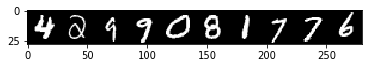

model predictions are: 
[ 4.  3.  9.  9.  0.  8.  1.  7.  7.  6.]
<NDArray 10 @gpu(0)>


In [51]:
import matplotlib.pyplot as plt

def model_predict(net,data):
    output = net(data.as_in_context(model_ctx))
    return nd.argmax(output, axis=1)

# let's sample 10 random data points from the test set
sample_data = mx.gluon.data.DataLoader(mx.gluon.data.vision.MNIST(train=False, transform=transform),
                              10, shuffle=True)
for i, (data, label) in enumerate(sample_data):
    data = data.as_in_context(ctx)
    print(data.shape)
    im = nd.transpose(data,(1,0,2,3))
    im = nd.reshape(im,(28,10*28,1))
    imtiles = nd.tile(im, (1,1,3))
    
    plt.imshow(imtiles.asnumpy())
    plt.show()
    pred=model_predict(net,data.reshape((-1,784)))
    print('model predictions are:', pred)
    break


## Next
[Overfitting and regularization from scratch](../chapter02_supervised-learning/regularization-scratch.ipynb)

For whinges or inquiries, [open an issue on  GitHub.](https://github.com/zackchase/mxnet-the-straight-dope)